# LeNet-5 (Convolutional Neural Network) の実装

このノートブックでは、畳み込みニューラルネットワーク（CNN）の古典的モデルであるLeNet-5をPyTorchを使って実装し、手書き数字データセットMNISTで学習と評価を行います。
前半のセクションではNumPyによるCNNの主要コンポーネントの概念を学び、後半のセクションでyTorchの強力な機能を活用して、より実践的なCNNモデル構築と学習パイプラインを体験します。

**参考論文:**
*   LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. *Proceedings of the IEEE*, 86(11), 2278-2324.

**このノートブックで学ぶこと:**
1.  PyTorchを使ったCNNモデルの定義 (`nn.Module`, `nn.Conv2d`, `nn.Linear`, `nn.MaxPool2d`)
2.  MNISTデータセットの準備とデータローダー (`torchvision.datasets`, `torch.utils.data.DataLoader`)
3.  モデルの学習ループ (損失計算、逆伝播、パラメータ更新)
4.  モデルの評価 (テストデータでの精度計算)
5.  GPUを利用した学習（オプション）

**前提知識:**
*   基本的なPythonプログラミング
*   NumPyの基本的な操作
*   （推奨）MLPのスクラッチ実装経験（mlpノートブック）
*   CNNの基本的な構成要素（畳み込み、プーリング）の概念理解（本ノートブックのセクション2または同等の知識）
*   PyTorchの基本的なテンサー操作（あれば尚良いですが、なくても進められます）

## 1. 必要なライブラリのインポート

In [1]:
import numpy as np
import matplotlib.pyplot as plt
print("numpy version:", np.__version__)

numpy version: 1.26.4


## 2. CNNの主要コンポーネントとNumPyによる実装

CNNは主に、畳み込み層、活性化関数、プーリング層、そして最後に全結合層を組み合わせて構成されます。

### 2.1 畳み込み演算 (Convolution Operation)

*   **概念:**
    畳み込み演算は、画像のようなグリッド構造を持つデータから局所的な特徴を抽出するための主要な演算です。入力画像（または特徴マップ）に対して、**カーネル**（またはフィルタ）と呼ばれる小さな行列をスライドさせながら、各位置で内積（要素ごとの積の和）を計算します。
    *   **カーネル (Kernel / Filter):** 抽出したい特徴（例: エッジ、コーナー）のパターンを表す小さな重み行列。学習可能なパラメータです。
    *   **特徴マップ (Feature Map):** 1つのカーネルを適用して得られる出力。入力の特定の特徴がどこに存在するかを示します。通常、1つの畳み込み層は複数のカーネルを持ち、複数の特徴マップを生成します。
    *   **パラメータ共有 (Parameter Sharing):** 1つの特徴マップ内では、同じカーネルが入力画像の全ての場所で使われます。これにより、モデルのパラメータ数を大幅に削減し、平行移動不変性（特徴が画像のどこにあっても検出できる性質）を獲得します。
    *   **局所的受容野 (Local Receptive Field):** カーネルは入力の小さな局所領域のみを参照します。

*   **主要なパラメータ:**
    *   **カーネルサイズ (Kernel Size):** カーネルの高さと幅（例: 3x3, 5x5）。
    *   **ストライド (Stride):** カーネルを入力上でスライドさせる際の移動量（ステップサイズ）。ストライドを大きくすると、出力される特徴マップのサイズは小さくなります。
    *   **パディング (Padding):** 入力画像の周囲にゼロなどの値を追加すること。主な目的は以下の2つです。
        1.  出力特徴マップの空間的次元が入力よりも小さくなるのを防ぐ（または制御する）。
        2.  画像の境界付近のピクセルもカーネルの中心として扱えるようにする。
            *   'valid' パディング: パディングなし。出力サイズは小さくなる。
            *   'same' パディング: 出力サイズが入力サイズと同じになるようにパディングする（ストライドが1の場合）。

*   **多チャネル入力・多チャネル出力:**
    *   入力がカラー画像（例: 3チャネルRGB）の場合、カーネルも同じチャネル数を持ちます（例: 3x3x3）。各チャネルごとの畳み込み結果を合計し、バイアスを加えて1つの出力特徴マップの要素とします。
    *   複数のカーネルを使用することで、出力も多チャネルの特徴マップになります。各カーネルが異なる特徴を抽出します。

#### 2.1.1 単一チャネル入力、単一カーネルの畳み込み (順伝播)

In [2]:
def convolve2d_single_channel(image, kernel, stride=1, padding=0):
    '''
    単一チャネル画像と単一カーネルによる2D畳み込み演算（順伝播）
    parameters:
        image: 入力画像（高さ，幅）
        kernel: 畳み込みカーネル（カーネル高さ，カーネル幅）
        stride: ストライドのサイズ
        padding(int or str): パディング量 intなら上下左右に同じ， 'valid'ならパディングなし，'same'なら出力サイズを入力と同じにする
    returns:
        np.array: 出力特徴マップ
    '''

    # パディングの処理
    if isinstance(padding, str):
        if padding == 'valid':
            pad_h, pad_w = 0, 0
        elif padding == 'same':
            # 簡単のためstride=1と仮定
            if stride != 1:
                raise ValueError("For 'same' padding, stride must be 1.")
            pad_h = (kernel.shape[0] - 1) // 2
            pad_w = (kernel.shape[1] - 1) // 2
        else:
            raise ValueError("Invalid padding type. Use 'valid' or 'same'.")
    elif isinstance(padding, int):
        pad_h, pad_w = padding, padding
    else:
        raise TypeError("Padding must be an int or str")
    
    image_padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)

    # カーネルサイズ
    k_h, k_w = kernel.shape
    # 画像サイズ（パディング後）
    img_h_padded, img_w_padded = image_padded.shape

    # 出力特徴マップのサイズ計算
    out_h = (img_h_padded - k_h) // stride + 1
    out_w = (img_w_padded - k_w) // stride + 1

    output_feature_map = np.zeros((out_h, out_w))

    # 畳み込み演算
    for y_out in range(out_h):
        for x_out in range(out_w):
            # カーネルを適用する領域の開始位置
            y_start = y_out * stride 
            x_start = x_out * stride
            # 領域をスライス
            image_slice = image_padded[y_start:y_start+k_h, x_start:x_start+k_w]
            # 要素ごとの内積
            output_feature_map[y_out, x_out] = np.sum(image_slice * kernel)

    return output_feature_map

In [3]:
# テスト
print("--- 畳み込みテスト (単一チャネル) ---")
test_image_gray = np.array([[1, 2, 3, 0, 1],
                            [0, 1, 2, 3, 0],
                            [1, 0, 1, 2, 3],
                            [3, 1, 0, 1, 2],
                            [2, 3, 1, 0, 1]], dtype=np.float32)

kernel_edge_x = np.array([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=np.float32) # x方向のエッジ検出（ソーベルフィルタ風）

kernel_blur = np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]], dtype=np.float32) / 9.0 # ボックスブラー

print("入力画像:\n", test_image_gray)
print("\nエッジ検出カーネル:\n", kernel_edge_x)
output_edge = convolve2d_single_channel(test_image_gray, kernel_edge_x, stride=1, padding='valid')
print("\n出力 (エッジ検出, valid padding):\n", output_edge)

output_edge_same = convolve2d_single_channel(test_image_gray, kernel_edge_x, stride=1, padding='same')
print("\n出力 (エッジ検出, same padding):\n", output_edge_same)

print("\nブラーカーネル:\n", kernel_blur)
output_blur_padded1 = convolve2d_single_channel(test_image_gray, kernel_blur, stride=1, padding=1)
print("\n出力 (ブラー, padding=1):\n", output_blur_padded1)

--- 畳み込みテスト (単一チャネル) ---
入力画像:
 [[1. 2. 3. 0. 1.]
 [0. 1. 2. 3. 0.]
 [1. 0. 1. 2. 3.]
 [3. 1. 0. 1. 2.]
 [2. 3. 1. 0. 1.]]

エッジ検出カーネル:
 [[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]

出力 (エッジ検出, valid padding):
 [[ 6.  4. -4.]
 [-1.  6.  4.]
 [-7. -1.  6.]]

出力 (エッジ検出, same padding):
 [[ 5.  6. -2. -6. -3.]
 [ 4.  6.  4. -4. -8.]
 [ 2. -1.  6.  4. -8.]
 [ 5. -7. -1.  6. -4.]
 [ 7. -5. -6.  2. -1.]]

ブラーカーネル:
 [[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

出力 (ブラー, padding=1):
 [[0.44444445 1.         1.22222221 1.         0.44444445]
 [0.55555558 1.22222233 1.55555558 1.66666675 1.        ]
 [0.66666669 1.         1.22222233 1.55555558 1.22222233]
 [1.11111116 1.33333349 1.         1.22222233 1.        ]
 [1.         1.11111116 0.66666669 0.55555558 0.44444445]]


#### 2.1.2 多チャネル入力、多カーネル（多チャネル出力）の畳み込み (順伝播)

実際のCNNでは、入力は複数のチャネル（例: RGB画像なら3チャネル、前の畳み込み層の出力なら複数の特徴マップ）を持ち、畳み込み層も複数のカーネルを持って複数の出力特徴マップを生成します。

*   **入力:** `(チャンネル数_入力, 高さ_入力, 幅_入力)`
*   **カーネル:** `(チャンネル数_出力, チャンネル数_入力, 高さ_カーネル, 幅_カーネル)`
    *   `チャンネル数_出力` は、この畳み込み層が生成する特徴マップの数（つまり、使用するカーネルの数）です。
    *   各カーネルは、入力の全チャネルを考慮します（深さ方向にも畳み込む）。
*   **出力:** `(チャンネル数_出力, 高さ_出力, 幅_出力)`
*   **バイアス:** 各出力チャネル（各カーネル）ごとに1つのバイアス値があります。

**計算の流れ（1つの出力特徴マップ $k$ の要素 $(y_{out}, x_{out})$ について）:**
1.  $k$番目のカーネル（形状: `(チャンネル数_入力, 高さ_カーネル, 幅_カーネル)`）を取得します。
2.  入力画像の対応する局所領域（形状: `(チャンネル数_入力, 高さ_カーネル, 幅_カーネル)`）を取得します。
3.  カーネルと入力領域の要素ごとの積を計算し、その全ての和を取ります。
4.  $k$番目のバイアス $b_k$ を加えます。

In [4]:
def convolve2d_multi_channel(input_volume, kernels, biases, stride=1, padding=0):
    '''
    多チャネル入力，多カーネルによる2D畳み込み演算（順伝播）
    parameters:
        input_volume: 入力ボリューム（チャネル数，高さ，幅）
        kernels: 畳み込みカーネル（カーネル数，チャネル数，カーネル高さ，カーネル幅）
        biases: バイアス項（カーネル数）
        stride: ストライドのサイズ
        padding(int or str): パディング
    returns:
        np.array: 出力特徴マップ（カーネル数，高さ，幅）
    '''
    n_input_channels, img_h, img_w = input_volume.shape
    n_output_channels, _, k_h, k_w = kernels.shape

    if kernels.shape[1] != n_input_channels:
        raise ValueError("Number of input channels must match the second dimension of kernels.")
    if len(biases) != n_output_channels:
        raise ValueError("Length of biases must match the number of output channels.")
    
    # パディングの処理
    if isinstance(padding, str):
        if padding == 'valid': pad_val = 0
        elif padding == 'same':
            if stride != 1:
                raise ValueError("For 'same' padding, stride must be 1.")
            pad_val = (k_h - 1) // 2
        else:
            raise ValueError("Invalid padding type. Use 'valid' or 'same'.")
    elif isinstance(padding, int):
        pad_val = padding
    else:
        raise TypeError("Padding must be an int or str")
    
    # 出力サイズ計算
    img_h_padded = img_h + 2 * pad_val
    img_w_padded = img_w + 2 * pad_val
    out_h = (img_h_padded - k_h) // stride + 1
    out_w = (img_w_padded - k_w) // stride + 1

    output_volume = np.zeros((n_output_channels, out_h, out_w))

    input_volume_padded = np.pad(input_volume,
                                    ((0, 0), (pad_val, pad_val), (pad_val, pad_val)),
                                    mode='constant', constant_values=0) # チャンネル方向はパディングしない
    
    # 各出力チャネル（各カーネル）について計算
    for k_out_idx in range(n_output_channels):
        current_kernel_set = kernels[k_out_idx]
        current_bias = biases[k_out_idx]

        # 出力特徴マップの各要素を計算
        for y_out in range(out_h):
            for x_out in range(out_w):
                y_start = y_out * stride
                x_start = x_out * stride
                
                # 入力ボリュームのスライスを取得（チャネル数，高さ，幅）
                input_slice = input_volume_padded[:, y_start:y_start+k_h, x_start:x_start+k_w]

                # 畳み込み：（カーネルとスライス要素ごとの内積）＋ バイアス
                output_volume[k_out_idx, y_out, x_out] = np.sum(input_slice * current_kernel_set) + current_bias

    return output_volume

In [5]:
# テスト
print("\n--- 畳み込みテスト (多チャネル) ---")
# 2チャネル入力画像 (3x3)
test_image_multi = np.array([
    [[1,2,3], [0,1,2], [1,0,1]], # Channel 0
    [[0,1,0], [1,0,1], [0,1,0]]  # Channel 1
], dtype=np.float32)

# 1つの出力チャネルを生成するカーネル群 (1出力チャネル, 2入力チャネル, 2x2カーネル)
kernels_multi_1out = np.array([
    [ # Output channel 0
        [[1,0], [0,1]], # Kernel for input channel 0
        [[0,1], [1,0]]  # Kernel for input channel 1
    ]
], dtype=np.float32)
biases_multi_1out = np.array([0.5], dtype=np.float32) # 出力チャネル0のバイアス

output_multi_1 = convolve2d_multi_channel(test_image_multi, kernels_multi_1out, biases_multi_1out, stride=1, padding='valid')
print("入力ボリューム (2x3x3):\n", test_image_multi)
print("\nカーネル (1x2x2x2):\n", kernels_multi_1out)
print("\nバイアス (1,):\n", biases_multi_1out)
print("\n出力ボリューム (1x2x2, valid padding):\n", output_multi_1)


--- 畳み込みテスト (多チャネル) ---
入力ボリューム (2x3x3):
 [[[1. 2. 3.]
  [0. 1. 2.]
  [1. 0. 1.]]

 [[0. 1. 0.]
  [1. 0. 1.]
  [0. 1. 0.]]]

カーネル (1x2x2x2):
 [[[[1. 0.]
   [0. 1.]]

  [[0. 1.]
   [1. 0.]]]]

バイアス (1,):
 [0.5]

出力ボリューム (1x2x2, valid padding):
 [[[4.5 4.5]
  [0.5 4.5]]]


In [6]:
# 2つの出力チャネルを生成するカーネル群 (2出力チャネル, 2入力チャネル, 2x2カーネル)
kernels_multi_2out = np.array([
    [ # Output channel 0 (上記と同じ)
        [[1,0], [0,1]], 
        [[0,1], [1,0]]  
    ],
    [ # Output channel 1
        [[0.5,0.5], [0.5,0.5]], # Kernel for input channel 0
        [[-1,-1], [-1,-1]]      # Kernel for input channel 1
    ]
], dtype=np.float32)
biases_multi_2out = np.array([0.5, -0.2], dtype=np.float32) # 出力チャネル0と1のバイアス

output_multi_2 = convolve2d_multi_channel(test_image_multi, kernels_multi_2out, biases_multi_2out, stride=1, padding=0)
print("\nカーネル (2x2x2x2):\n", kernels_multi_2out)
print("\nバイアス (2,):\n", biases_multi_2out)
print("\n出力ボリューム (2x2x2, padding=0):\n", output_multi_2)


カーネル (2x2x2x2):
 [[[[ 1.   0. ]
   [ 0.   1. ]]

  [[ 0.   1. ]
   [ 1.   0. ]]]


 [[[ 0.5  0.5]
   [ 0.5  0.5]]

  [[-1.  -1. ]
   [-1.  -1. ]]]]

バイアス (2,):
 [ 0.5 -0.2]

出力ボリューム (2x2x2, padding=0):
 [[[ 4.5         4.5       ]
  [ 0.5         4.5       ]]

 [[-0.2         1.79999995]
  [-1.20000005 -0.2       ]]]


### 2.2 活性化関数 (Activation Functions)

畳み込み層や全結合層の出力には、通常、活性化関数が適用され、ネットワークに非線形性を導入します。
MLPの実装で紹介したSigmoidやReLUがCNNでも同様に使われます。特に隠れ層ではReLUが一般的です。
実装はMLPのノートブックのものを再利用できます。

In [7]:
# (MLPノートブックから再掲)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

# LeNet-5の原論文ではtanhのscaled版が使われることもある
def tanh(x):
    return np.tanh(x)

In [8]:
# 活性化関数は要素ごとに適用される
test_conv_output = output_multi_2 # 前のセルの出力を使う
activated_relu = relu(test_conv_output)
activated_sigmoid = sigmoid(test_conv_output)
activated_tanh = tanh(test_conv_output)

print("畳み込み出力:\n", test_conv_output)
print("ReLU適用後:\n", activated_relu)
print("Sigmoid適用後:\n", activated_sigmoid)
print("Tanh適用後:\n", activated_tanh)

畳み込み出力:
 [[[ 4.5         4.5       ]
  [ 0.5         4.5       ]]

 [[-0.2         1.79999995]
  [-1.20000005 -0.2       ]]]
ReLU適用後:
 [[[4.5        4.5       ]
  [0.5        4.5       ]]

 [[0.         1.79999995]
  [0.         0.        ]]]
Sigmoid適用後:
 [[[0.98901306 0.98901306]
  [0.62245933 0.98901306]]

 [[0.450166   0.85814893]
  [0.23147521 0.450166  ]]]
Tanh適用後:
 [[[ 0.99975321  0.99975321]
  [ 0.46211716  0.99975321]]

 [[-0.19737532  0.94680601]
  [-0.83365462 -0.19737532]]]


### 2.3 プーリング演算 (Pooling Operation)

*   **概念:**
    プーリング層は、特徴マップの空間的な次元を削減（ダウンサンプリング）し、計算量を減らし、過学習を抑制し、入力の小さな平行移動に対する不変性を高める役割を果たします。
    畳み込み層と同様に、小さなウィンドウ（プーリングウィンドウ）を特徴マップ上でスライドさせ、ウィンドウ内の値から代表値を計算します。

*   **主な種類:**
    *   **マックスプーリング (Max Pooling):** ウィンドウ内の最大値を取る。最も一般的に使われます。
    *   **アベレージプーリング (Average Pooling):** ウィンドウ内の平均値を取る。

*   **主要なパラメータ:**
    *   **ウィンドウサイズ (Window Size / Pool Size):** プーリングを行う領域の高さと幅（例: 2x2）。
    *   **ストライド (Stride):** ウィンドウをスライドさせる際の移動量。通常、ウィンドウサイズと同じ値に設定し、ウィンドウが重ならないようにします（non-overlapping pooling）。

*   **処理の流れ（マックスプーリングの場合）:**
    1.  入力特徴マップ（通常は畳み込み層と活性化関数を経たもの）を用意します。
    2.  プーリングウィンドウをストライドに従ってスライドさせます。
    3.  各ウィンドウ位置で、ウィンドウ内の要素の最大値を計算し、出力特徴マップの対応する位置に格納します。
    プーリングは通常、各チャネル独立に行われます（出力チャネル数は入力チャネル数と同じ）。

In [9]:
def max_pool2d(input_feature_map, pool_size, stride):
    '''
    2Dマックスプーリング演算
    parameters:
        input_feature_map: 入力特徴マップ（高さ，幅）
        pool_size(int or tuple): プーリングサイズ（高さ，幅）
        stride(int or tuple): ストライドのサイズ
    returns:
        np.array: プーリング後の特徴マップ
    '''
    if input_feature_map.ndim == 2: # シングルチャネルの場合，次元を追加
        input_feature_map = input_feature_map[np.newaxis, :, :]

    n_channels, img_h, img_w = input_feature_map.shape

    if isinstance(pool_size, int):
        pool_h, pool_w = pool_size, pool_size
    else:
        pool_h, pool_w = pool_size
    
    if isinstance(stride, int):
        stride_h, stride_w = stride, stride
    else:
        stride_h, stride_w = stride

    out_h = (img_h - pool_h) // stride_h + 1
    out_w = (img_w - pool_w) // stride_w + 1

    output_pooled_map = np.zeros((n_channels, out_h, out_w))

    for c in range(n_channels):
        for y_out in range(out_h):
            for x_out in range(out_w):
                y_start = y_out * stride_h
                x_start = x_out * stride_w
                window = input_feature_map[c, y_start:y_start+pool_h, x_start:x_start+pool_w]
                output_pooled_map[c, y_out, x_out] = np.max(window)

    if output_pooled_map.shape[0] == 1: # シングルチャネルの場合は次元を削除
        return output_pooled_map.squeeze(axis=0)
    return output_pooled_map

In [10]:
# テスト
print("\n--- プーリングテスト ---")
test_map = np.array([[1,3,2,4],
                     [5,7,8,1],
                     [0,2,6,9],
                     [3,4,1,5]], dtype=np.float32)
print("入力特徴マップ:\n", test_map)

output_maxpool = max_pool2d(test_map, pool_size=2, stride=2)
print("\nマックスプーリング後 (2x2 window, stride 2):\n", output_maxpool)

test_map_multi_channel = activated_relu # 前のReLU活性化後の出力 (2チャネル, 2x2)
print("\n入力特徴マップ (多チャネル):\n", test_map_multi_channel)
if test_map_multi_channel.shape[1] >=2 and test_map_multi_channel.shape[2] >=2: # プーリング可能かチェック
    output_maxpool_multi = max_pool2d(test_map_multi_channel, pool_size=2, stride=1) # ウィンドウが重なるケース
    print("\n多チャネルマックスプーリング後 (2x2 window, stride 1):\n", output_maxpool_multi)
else:
    print("入力特徴マップが小さすぎるため、多チャネルプーリングテストをスキップします。")


--- プーリングテスト ---
入力特徴マップ:
 [[1. 3. 2. 4.]
 [5. 7. 8. 1.]
 [0. 2. 6. 9.]
 [3. 4. 1. 5.]]

マックスプーリング後 (2x2 window, stride 2):
 [[7. 8.]
 [4. 9.]]

入力特徴マップ (多チャネル):
 [[[4.5        4.5       ]
  [0.5        4.5       ]]

 [[0.         1.79999995]
  [0.         0.        ]]]

多チャネルマックスプーリング後 (2x2 window, stride 1):
 [[[4.5       ]]

 [[1.79999995]]]


### 2.4 全結合層 (Fully Connected Layer)

*   **概念:**
    CNNの最後の方では、畳み込み層とプーリング層で抽出された高レベルな特徴を使って、最終的な分類や回帰を行います。そのために、特徴マップを1次元のベクトルにフラット化（Flatten）し、MLPと同様の全結合層に入力します。
*   **実装:**
    MLPのノートブックで実装した線形変換（`np.dot(X, W) + b`）と活性化関数をそのまま利用できます。入力はフラット化されたベクトルになります。

In [11]:
def fully_connected_forward(flattened_input, W, b, activation_fn=None):
    '''
    全結合層の順伝播
    '''
    Z = np.dot(flattened_input, W) + b
    if activation_fn:
        A = activation_fn(Z)
        return A, Z
    return Z, Z

In [12]:
# 例: 前のプーリング出力をフラット化して全結合層に入力
if 'output_maxpool_multi' in locals() and output_maxpool_multi is not None:
    pooled_output_flat = output_maxpool_multi.reshape(output_maxpool_multi.shape[0], -1) # (チャネル数, H*W)
                                                                                     # またはバッチ処理を想定するなら (バッチサイズ, チャネル*H*W)
                                                                                     # ここでは1サンプル、多チャネルを1つのベクトルにフラット化
    pooled_output_flat_single_vector = output_maxpool_multi.ravel() # (チャネル数 * H_pooled * W_pooled, )
    print("プーリング出力 (フラット化前):\n", output_maxpool_multi)
    print("プーリング出力 (フラット化後):\n", pooled_output_flat_single_vector)

    # ダミーの重みとバイアス
    n_fc_inputs = pooled_output_flat_single_vector.shape[0]
    n_fc_outputs = 10 # 例: 10クラス分類
    W_fc = np.random.randn(n_fc_inputs, n_fc_outputs) * 0.01
    b_fc = np.zeros((1, n_fc_outputs))
    
    # 全結合層の出力 (活性化なし)
    fc_output, _ = fully_connected_forward(pooled_output_flat_single_vector.reshape(1, -1), W_fc, b_fc) 
                                                                                            # 入力は(1, n_fc_inputs)
    print("\n全結合層出力 (活性化なし):\n", fc_output)

    # 活性化あり (例: ReLU)
    fc_output_relu, _ = fully_connected_forward(pooled_output_flat_single_vector.reshape(1,-1), W_fc, b_fc, activation_fn=relu)
    print("\n全結合層出力 (ReLU活性化あり):\n", fc_output_relu)
else:
    print("前のプーリング出力が存在しないため、全結合層テストをスキップします。")

プーリング出力 (フラット化前):
 [[[4.5       ]]

 [[1.79999995]]]
プーリング出力 (フラット化後):
 [4.5        1.79999995]

全結合層出力 (活性化なし):
 [[-0.05850072  0.08564293 -0.06930517 -0.01531449  0.0564722   0.06742507
  -0.00216062 -0.04469021 -0.0196126  -0.04798154]]

全結合層出力 (ReLU活性化あり):
 [[0.         0.08564293 0.         0.         0.0564722  0.06742507
  0.         0.         0.         0.        ]]


## 3. LeNet-5 アーキテクチャの概要

LeNet-5は、手書き数字認識のために提案された初期のCNNアーキテクチャの一つです。
論文 (Figure 2, p.2285) に基づく典型的な構造は以下の通りです（層の数え方や細部は文献により多少異なります）。

1.  **入力:** 32x32ピクセルのグレースケール画像。
    *   論文では、入力値は-0.1 (背景) から 1.175 (前景) に正規化。

2.  **C1: 畳み込み層 (Convolutional Layer)**
    *   カーネル数: 6
    *   カーネルサイズ: 5x5
    *   ストライド: 1
    *   パディング: なし ('valid') → 出力特徴マップサイズ: (32-5+1) = 28x28
    *   出力: 6枚の 28x28 特徴マップ。
    *   活性化関数: Tanh (またはSigmoid)

3.  **S2: サブサンプリング層 (Subsampling / Pooling Layer)**
    *   タイプ: アベレージプーリング（論文では重みとバイアスも学習）
    *   ウィンドウサイズ: 2x2
    *   ストライド: 2
    *   出力: C1の各特徴マップに対応する6枚の 14x14 特徴マップ。
    *   活性化関数: Tanh (またはSigmoid)

4.  **C3: 畳み込み層**
    *   カーネル数: 16
    *   カーネルサイズ: 5x5
    *   ストライド: 1
    *   パディング: なし ('valid') → 出力特徴マップサイズ: (14-5+1) = 10x10
    *   **接続:** S2の6枚の特徴マップの様々な組み合わせから入力を受け取る（全てではない、Table I参照）。
    *   出力: 16枚の 10x10 特徴マップ。
    *   活性化関数: Tanh

5.  **S4: サブサンプリング層**
    *   タイプ: アベレージプーリング
    *   ウィンドウサイズ: 2x2
    *   ストライド: 2
    *   出力: C3の各特徴マップに対応する16枚の 5x5 特徴マップ。
    *   活性化関数: Tanh

6.  **C5: 畳み込み層 (全結合層として実装されることが多い)**
    *   カーネル数: 120
    *   カーネルサイズ: 5x5
    *   ストライド: 1
    *   入力: S4の全16枚の5x5特徴マップ。カーネルサイズが入力サイズと同じなので、実質的に全結合。
    *   出力: 120ユニットの1次元ベクトル (120枚の1x1特徴マップ)。
    *   活性化関数: Tanh

7.  **F6: 全結合層 (Fully Connected Layer)**
    *   入力ユニット数: 120 (C5の出力)
    *   出力ユニット数: 84
    *   活性化関数: Tanh

8.  **出力層:**
    *   入力ユニット数: 84 (F6の出力)
    *   出力ユニット数: 10 (数字の0から9に対応)
    *   活性化関数: 論文ではRBFユニットが使われているが、現代的にはSoftmax（多クラス分類）またはSigmoid（各クラスの独立確率）が一般的。MNISTならSoftmax。

**パラメータ数:**
LeNet-5はパラメータ共有により、見た目の接続数に対して学習可能なパラメータ数が大幅に削減されています。論文では約6万個の学習可能パラメータ。

## 4. PyTorchによるLeNet-5の実装とMNISTでの学習・評価

ここからは、PyTorchを使ってLeNet-5を実装し、実際にMNIST手書き数字データセットで学習と評価を行います。


### 4.1 PyTorch関連ライブラリのインポート

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# 利用可能ならGPUをデバイスとして設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.7.0+cpu
Torchvision Version: 0.22.0+cpu
Using device: cpu


### 4.2 MNISTデータセットの準備

PyTorchの`torchvision`ライブラリを使うと、MNISTのような標準的なデータセットを簡単にダウンロードし、前処理して利用できます。

*   **前処理 (`transforms`):**
    *   `transforms.ToTensor()`: PIL ImageやNumPy配列をPyTorch Tensorに変換し、ピクセル値を `[0, 1]` の範囲に正規化します。
    *   `transforms.Normalize((mean,), (std,))`: 指定された平均と標準偏差でテンソルを正規化します。MNISTの場合、グレースケールなので平均と標準偏差は1つの値です（一般的に0.1307と0.3081が使われます）。LeNet-5の原論文では入力範囲が-0.1から1.175とありましたが、ここでは一般的な正規化を行います。

In [14]:
# MNISTデータセットの前処理
# LeNet-5は32x32の入力を想定しているため、MNISTの28x28画像をリサイズ
transform = transforms.Compose([
    transforms.Resize((32, 32)), # 画像を32x32にリサイズ
    transforms.ToTensor(), # Tensorに変換
    transforms.Normalize((0.1307,), (0.3081,)) # MNISTの平均と標準偏差 (近似値)
])

# 訓練データセットのダウンロードと準備
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transform,
                                           download=True)

# テストデータセットのダウンロードと準備
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transform,
                                          download=True)

# データローダーの作成
# バッチサイズは学習の効率やメモリ使用量に応じて調整
batch_size = 64

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True) # 訓練データはシャッフル

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False) # テストデータはシャッフルしない

print(f"訓練データセットのサイズ: {len(train_dataset)}")
print(f"テストデータセットのサイズ: {len(test_dataset)}")
print(f"データローダーのバッチサイズ（訓練）: {len(train_loader)}")
print(f"データローダーのバッチサイズ（テスト）: {len(test_loader)}")

# データの形状確認 (1バッチ分)
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("\n1バッチの画像の形状:", images.shape) # (batch_size, channels, height, width) -> (64, 1, 32, 32)
print("1バッチのラベルの形状:", labels.shape) # (batch_size)

訓練データセットのサイズ: 60000
テストデータセットのサイズ: 10000
データローダーのバッチサイズ（訓練）: 938
データローダーのバッチサイズ（テスト）: 157

1バッチの画像の形状: torch.Size([64, 1, 32, 32])
1バッチのラベルの形状: torch.Size([64])


### 4.3 LeNet-5モデルの定義 (PyTorch)

`torch.nn.Module` を継承してLeNet-5モデルを定義します。
論文のアーキテクチャ (C1-S2-C3-S4-C5-F6-Output) に従います。
活性化関数は、論文では `tanh` のscaled版が使われていますが、ここではより現代的な `ReLU` を使うか、`nn.Tanh()` を使用します。今回は `nn.Tanh()` を使用してみます。
サブサンプリング層は、論文ではAverage Poolingで、かつ学習可能なパラメータがありましたが、ここでは一般的な `nn.AvgPool2d` (または `nn.MaxPool2d`) を使います。

In [15]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        # LeNet-5のアーキテクチャ
        # 入力: (batch_size, 1, 32, 32)

        # C1: 畳み込み層1
        # in_channels=1, out_channels=6, kernel_size=5
        # (32x32) -> (28x28) (padding=0, stride=1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.act1 = nn.Tanh() # またはnn.ReLU()

        # S2: サブサンプリング層（アベレージプーリング）
        # (28x28) -> (14x14) (kernel_size=2, stride=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: 畳み込み層2
        # in_channels=6, out_channels=16, kernel_size=5
        # (14x14) -> (10x10) (padding=0, stride=1)
        # 論文ではS2とC3の接続が複雑だが，ここでは単純に全接続を仮定
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()

        # S4: サブサンプリング層
        # (10x10) -> (5x5) (kernel_size=2, stride=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: 畳み込み層3
        # in_channels=16, out_channels=120, kernel_size=5
        # (5x5) -> (1x1) (padding=0, stride=1)
        # この層の出力は120次元のベクトル
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        # Flatten: C5の出力をフラット化する処理はforwardメソッド内で行う
        # C5の出力は (batch_size, 120, 1, 1) なので、フラット化すると (batch_size, 120) になる

        # F6: 全結合層
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.act4 = nn.Tanh()

        # Output層: 全結合層
        self.fc2 = nn.Linear(in_features=84, out_features=num_classes)
        # Softmaxは損失関数であるCrossEntropyLossが内部で行うため、ここでは定義しない

    def forward(self, x):
        # C1 -> S2
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        # C3 -> S4
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        # C5
        x = self.conv3(x)
        x = self.act3(x)

        # Flatten
        x = torch.flatten(x, 1) # バッチ次元を除いてフラット化（batch_size, 120）

        # F6
        x = self.fc1(x)
        x = self.act4(x)

        # Output
        x = self.fc2(x)
        return x

In [16]:
# モデルのインスタンス化とデバイスへの転送
model_lenet_torch = LeNet5(num_classes=10).to(device)
print("\nPyTorch LeNet-5 Model Architecture:\n", model_lenet_torch)

# ダミー入力でフォワードパスのテスト
dummy_input_torch = torch.randn(batch_size, 1, 32, 32).to(device) # (batch, channel, H, W)
output_dummy = model_lenet_torch(dummy_input_torch)
print("\nDummy Input Shape:", dummy_input_torch.shape)
print("Dummy Output Shape (Logits):", output_dummy.shape) # (batch_size, num_classes)


PyTorch LeNet-5 Model Architecture:
 LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (act1): Tanh()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (act2): Tanh()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (act3): Tanh()
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (act4): Tanh()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

Dummy Input Shape: torch.Size([64, 1, 32, 32])
Dummy Output Shape (Logits): torch.Size([64, 10])


### 4.4 損失関数とOptimizerの定義 (PyTorch)

MNISTのような多クラス分類問題では、一般的に**交差エントロピー損失 (Cross-Entropy Loss)** が使われます。
PyTorchの `nn.CrossEntropyLoss` は、内部でSoftmax活性化と負の対数尤度損失を組み合わせて計算してくれるため、モデルの出力層ではSoftmaxを適用する必要はありません（ロジットを直接渡します）。

Optimizerとしては、SGDやAdamなどが使えます。

In [17]:
# 損失関数
criterion_lenet = nn.CrossEntropyLoss() # ソフトマックスは内部で行われる

# Optimizer
optimizer_lenet = optim.Adam(model_lenet_torch.parameters(), lr=0.001) # opt.SGDも使える

### 4.5 PyTorchモデルの学習ループ (MNIST)

学習ループは、データローダーからバッチごとにデータを取得し、以下の処理を繰り返します。
1.  入力とラベルを適切なデバイス（CPUまたはGPU）に転送。
2.  Optimizerの勾配をリセット。
3.  モデルで順伝播を行い、出力を得る。
4.  損失を計算。
5.  逆伝播で勾配を計算。
6.  Optimizerでパラメータを更新。

In [20]:
num_epochs_lenet = 10 # エポック数
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print(f"\nLeNet-5 学習開始 (MNISTデータ、{num_epochs_lenet} epochs)...")

for epoch in range(num_epochs_lenet):
    model_lenet_torch.train() # モデルを訓練モードに設定
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 順伝播
        outputs = model_lenet_torch(images)
        loss = criterion_lenet(outputs, labels)

        # 逆伝播と最適化
        optimizer_lenet.zero_grad()
        loss.backward()
        optimizer_lenet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i+1) % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs_lenet}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss_train = running_loss / len(train_loader)
    epoch_acc_train = 100 * correct_train / total_train
    train_losses.append(epoch_loss_train)
    train_accuracies.append(epoch_acc_train)

    # -- 各エポック終了時にテストデータで評価 --
    model_lenet_torch.eval() # モデルを評価モードに設定
    correct_test = 0
    total_test = 0
    running_test_loss = 0.0

    with torch.no_grad(): # 勾配計算を無効化
        for images_test, labels_test in test_loader:
            images_test = images_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = model_lenet_torch(images_test)
            loss_test = criterion_lenet(outputs_test, labels_test)
            running_test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test.data, 1)
            total_test += labels_test.size(0)
            correct_test += (predicted_test == labels_test).sum().item()

    epoch_loss_test = running_test_loss / len(test_loader)
    epoch_acc_test = 100 * correct_test / total_test
    test_losses.append(epoch_loss_test)
    test_accuracies.append(epoch_acc_test)

    print(f"Epoch [{epoch+1}/{num_epochs_lenet}]"
          f"Train Loss: {epoch_loss_train:.4f}, Train Acc: {epoch_acc_train:.2f}% - "
          f"Test Loss: {epoch_loss_test:.4f}, Test Acc: {epoch_acc_test:.2f}%")

print("LeNet-5 学習完了")



LeNet-5 学習開始 (MNISTデータ、10 epochs)...
Epoch [1/10], Step [200/938], Loss: 0.0236
Epoch [1/10], Step [400/938], Loss: 0.1150
Epoch [1/10], Step [600/938], Loss: 0.0545
Epoch [1/10], Step [800/938], Loss: 0.0279
Epoch [1/10]Train Loss: 0.0702, Train Acc: 97.89% - Test Loss: 0.0573, Test Acc: 98.25%
Epoch [2/10], Step [200/938], Loss: 0.0226
Epoch [2/10], Step [400/938], Loss: 0.0842
Epoch [2/10], Step [600/938], Loss: 0.0056
Epoch [2/10], Step [800/938], Loss: 0.0078
Epoch [2/10]Train Loss: 0.0497, Train Acc: 98.51% - Test Loss: 0.0484, Test Acc: 98.41%
Epoch [3/10], Step [200/938], Loss: 0.0339
Epoch [3/10], Step [400/938], Loss: 0.0111
Epoch [3/10], Step [600/938], Loss: 0.0027
Epoch [3/10], Step [800/938], Loss: 0.0028
Epoch [3/10]Train Loss: 0.0394, Train Acc: 98.78% - Test Loss: 0.0425, Test Acc: 98.66%
Epoch [4/10], Step [200/938], Loss: 0.0312
Epoch [4/10], Step [400/938], Loss: 0.0532
Epoch [4/10], Step [600/938], Loss: 0.0061
Epoch [4/10], Step [800/938], Loss: 0.0019
Epoch [4/1

### 4.6 学習結果のプロットと最終評価

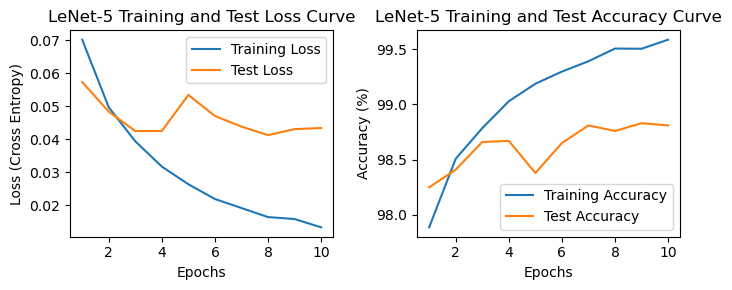


最終テスト精度: 98.81%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Confusion Matrix:


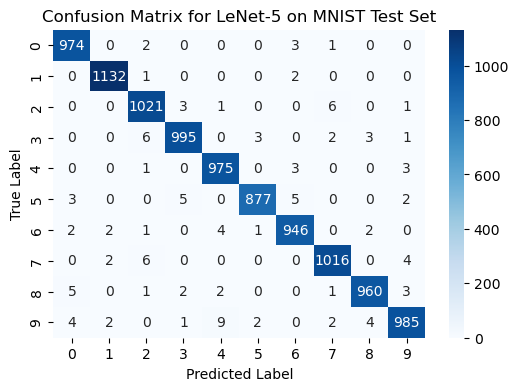

In [24]:
# 学習曲線 (損失) のプロット
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_lenet + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs_lenet + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.title('LeNet-5 Training and Test Loss Curve')
plt.legend()

# 学習曲線 (精度) のプロット
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_lenet + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs_lenet + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('LeNet-5 Training and Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n最終テスト精度: {test_accuracies[-1]:.2f}%")

# テストデータセットでの最終的な詳細な評価
model_lenet_torch.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_lenet_torch(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for LeNet-5 on MNIST Test Set')
plt.show()

## 5. 考察: NumPyスクラッチ実装とPyTorch実装

*   **NumPyによるCNNコンポーネントの実装の意義:**
    *   畳み込みやプーリングといったCNNの核となる演算の低レベルな動作原理を理解する上で非常に有益でした。パラメータ共有や局所的受容野がどのように特徴抽出に寄与するかのイメージを掴むことができました。

*   **PyTorchへの移行によるメリット:**
    *   **自動微分 (`autograd`):** 複雑なCNNのバックプロパゲーションを手動で実装する必要がなくなり、`loss.backward()` の一言で全てのパラメータの勾配が計算されます。これにより、モデル構造の変更や新しい損失関数の試行が格段に容易になりました。
    *   **最適化されたレイヤー (`nn.Conv2d`, `nn.AvgPool2d`, `nn.Linear`):** これらのモジュールは内部で効率的に実装されており、手動のNumPyループよりもはるかに高速です。また、初期化やパラメータ管理も容易です。
    *   **GPUサポート:** `model.to(device)` と `data.to(device)` だけでGPUを利用した高速計算が可能になり、学習時間を大幅に短縮できます（特に大規模モデルやデータの場合）。
    *   **データ処理パイプライン (`torchvision`, `DataLoader`):** 標準的なデータセットのダウンロード、前処理、バッチ化、シャッフルなどが簡単に行え、学習コードの主要部分に集中できます。
    *   **コードの簡潔さと可読性:** モデルの構造や学習ループが非常にシンプルに記述でき、何をしているかが見通しやすくなりました。

*   **LeNet-5の学習結果について:**
    *   適切なハイパーパラメータ（学習率、エポック数、バッチサイズなど）を設定すれば、PyTorchで実装したLeNet-5はMNISTデータセットに対して高い精度（通常98-99%程度）を達成できます。
    *   学習曲線を見ることで、過学習の兆候や学習の進捗を監視できます。
    *   Confusion Matrixは、モデルがどの数字を間違えやすいかを視覚的に示してくれます。